In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from camera_properties_loader import CameraPropertiesLoader
import vpi

In [118]:
img_path = "/media/devansh/t7shield/wildfire_thermal/2.images/gascola_3/images_raw_synced/657.png"
# img_path = "/media/devansh/t7shield/wildfire_thermal/2.images/gascola_1/images_raw_synced/878.png"
# img_path = "/media/devansh/t7shield/wildfire_thermal/2.images/gascola_2/images_raw_synced/841.png"
img_raw = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

left_raw, right_raw = np.split(img_raw, 2, axis=1)

# print image shape, dtype
print(img_raw.shape)
print(img_raw.dtype)

(512, 1280)
uint16


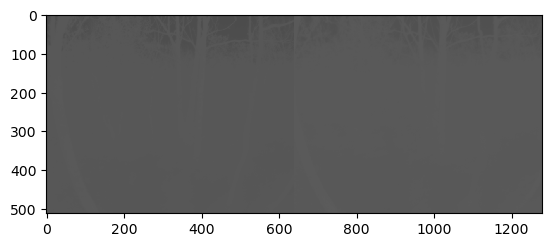

In [119]:
img_8_scaled = np.uint8(img_raw / 256.0)
# visualize image
plt.imshow(cv2.cvtColor(img_8_scaled.astype(np.uint8), cv2.COLOR_GRAY2RGB))

[ 15869  22787 289024]
[19441.         20659.66666667]
22914.2
19477.56


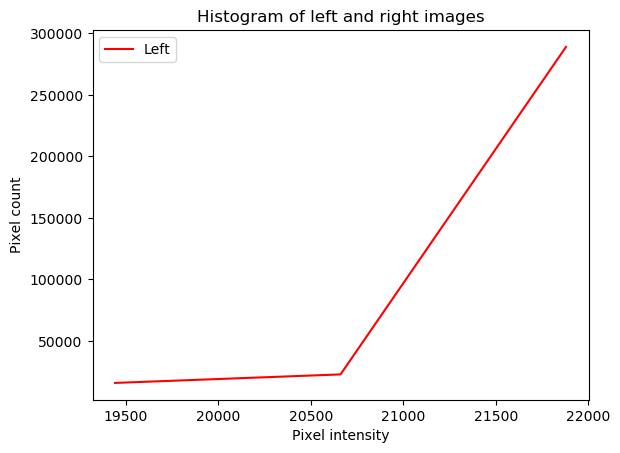

In [120]:
# plot histogram of left and right images as 2 separate line plots
plt.figure()

left_hist, bin_edges = np.histogram(left_raw, bins=3)

print(left_hist)
print(bin_edges[0:2])
print(np.percentile(bin_edges, 95))
print(np.percentile(bin_edges, 1))

np.mean(left_raw)

plt.plot(bin_edges[:-1], left_hist, color='r')
# plt.plot(np.histogram(right_raw, bins=2**8, range=(0,(2**16)-1))[0], color='b')
plt.xlabel('Pixel intensity')
plt.ylabel('Pixel count')
plt.title('Histogram of left and right images')
plt.legend(['Left', 'Right'])
plt.show()

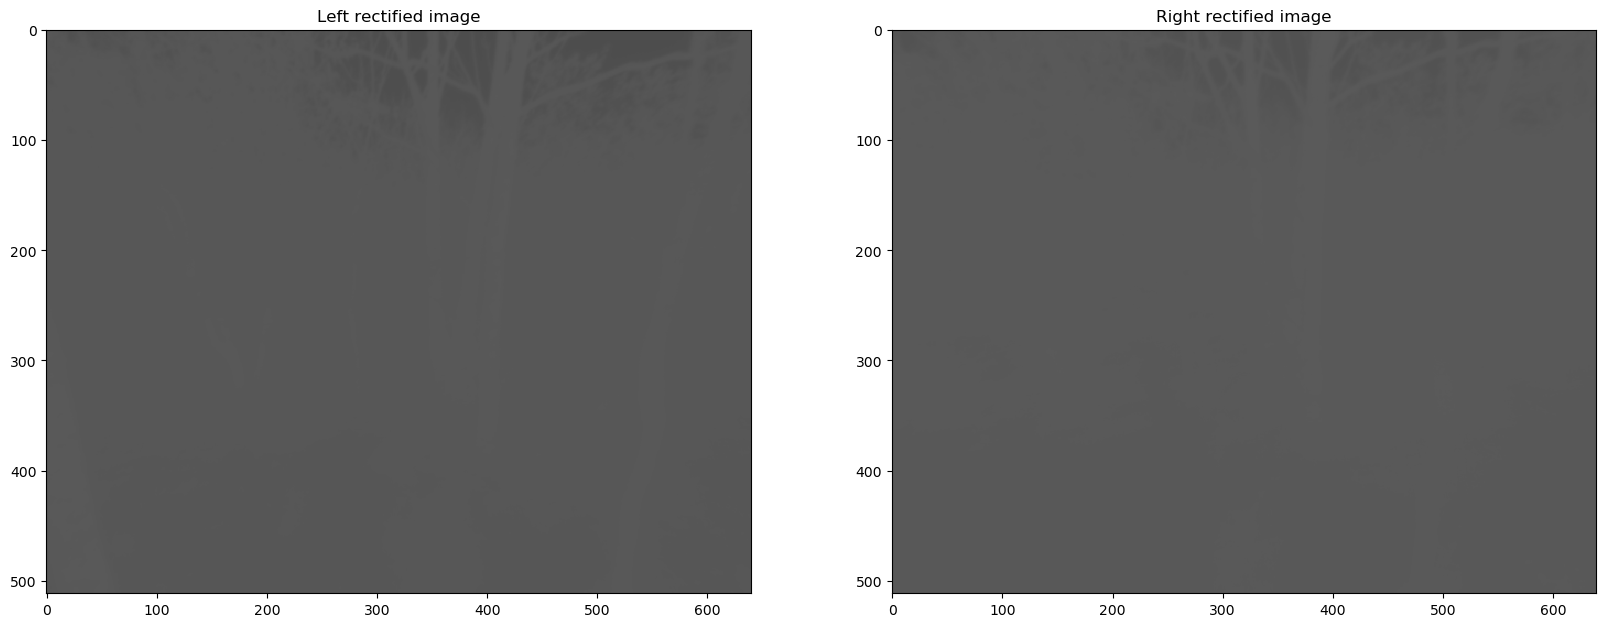

In [121]:
# rectify images
left_camera_properties = CameraPropertiesLoader('./thermal_left.yaml')
right_camera_properties = CameraPropertiesLoader('./thermal_right.yaml')

K_left, D_left, R_left, t_left = left_camera_properties.get_properties()
K_right, D_right, R_right, t_right = right_camera_properties.get_properties()

R = np.dot(R_right, R_left.T)  # Rotation matrix
T = t_right - np.dot(R, t_left)  # Translation vector

baseline = np.abs(T[1])
focal_length = (K_left[0][0] + K_left[1][1]) / 2

image_size = left_raw.shape[1], left_raw.shape[0]

# Compute the rectification maps
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K_left, D_left, K_right, D_right, image_size, R, T
)

map1x, map1y = cv2.initUndistortRectifyMap(
    K_left, D_left, R1, P1, image_size, cv2.CV_32FC1
)
map2x, map2y = cv2.initUndistortRectifyMap(
    K_right, D_right, R2, P2, image_size, cv2.CV_32FC1
)

left_rectified_16 = cv2.remap(
    left_raw, map1x, map1y, cv2.INTER_LINEAR
)
right_rectified_16 = cv2.remap(
    right_raw, map2x, map2y, cv2.INTER_LINEAR
)

left_rectified_8 = np.uint8(left_rectified_16 / 256.0)
right_rectified_8 = np.uint8(right_rectified_16 / 256.0)

# 2 subplots, 1 row, 2 columns (left, right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(left_rectified_8, cv2.COLOR_GRAY2RGB))
ax1.set_title('Left rectified image')
ax2.imshow(cv2.cvtColor(right_rectified_8, cv2.COLOR_GRAY2RGB))
ax2.set_title('Right rectified image')
plt.show()

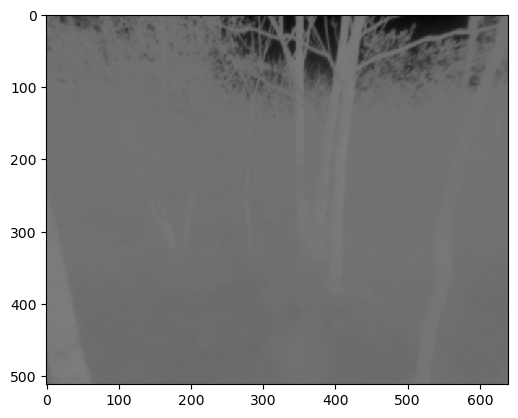

In [139]:
def gamma_correction(image, gamma, new_min):
    # Ensure the image is in float32 format for the gamma correction
    image_float = image.astype(np.float32)
    
    # Apply gamma correction
    corrected_image = ((image_float - np.min(image_float))**gamma) + new_min
    
    # Clip values to the valid intensity range (0 to 65535 for a 16-bit image)
    corrected_image = np.clip(corrected_image, 0, 65535)
    
    # Convert back to uint16 format
    corrected_image = corrected_image.astype(np.uint16)
    
    return corrected_image

left_16 = gamma_correction(left_rectified_16, 0.6, 0)

# show image
plt.imshow(cv2.cvtColor(left_16, cv2.COLOR_GRAY2RGB))

In [123]:
def compute_ssd(left_patch, right_patch):
    """Compute the sum of squared differences (SSD) between two patches."""
    return np.sum((left_patch - right_patch) ** 2)

In [124]:
def compute_ncc(left_patch, right_patch):
    if left_patch.shape != right_patch.shape:
        raise ValueError("Left and right patches must have the same shape")
    
    if left_patch.ndim != 2:
        raise ValueError("Left and right patches must be 2D arrays")
    
    # Compute the mean of each patch
    left_mean = np.mean(left_patch)
    right_mean = np.mean(right_patch)
    
    # Compute the standard deviation of each patch
    left_std = np.std(left_patch)
    right_std = np.std(right_patch)

    # Handle cases where standard deviation is close to zero
    left_std = max(left_std, 1e-10)
    right_std = max(right_std, 1e-10)

    # Compute the normalized cross-correlation
    ncc = np.sum((left_patch - left_mean) * (right_patch - right_mean)) / (left_std * right_std * left_patch.size) + 1e-10
    return ncc

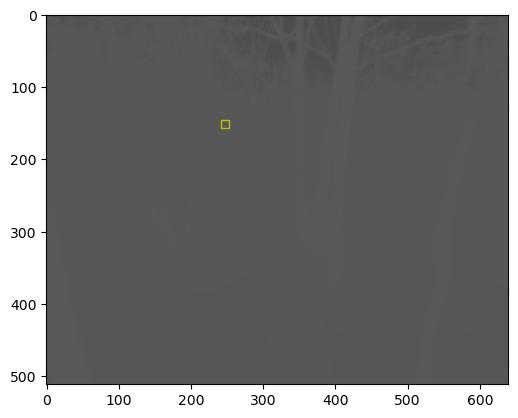

In [125]:
# select point in left image
left_point = (247, 150)
window_size = 5
left_patch = left_rectified_8[
    left_point[1] - window_size : left_point[1] + window_size + 1,
    left_point[0] - window_size : left_point[0] + window_size + 1
]
# visualize left point and patch as x and yellow bbox respectively
plt.imshow(cv2.cvtColor(left_rectified_8, cv2.COLOR_GRAY2RGB))
# plt.plot(left_point[0], left_point[1], 'rx')
plt.gca().add_patch(
    plt.Rectangle(
        (left_point[0] - window_size, left_point[1] - window_size),
        2 * window_size + 1,
        2 * window_size + 1,
        linewidth=1,
        edgecolor='y',
        facecolor='none'
    )
)
plt.show()

In [126]:
def display_match_results(left_point, ncc_values, left_rectified_8, right_rectified_8, window_size, eval_matric='ssd', title=''):
    # plot left, right image side by side. Remove axis ticks and labels
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(title, fontsize=20, fontweight='bold') 
    fig.add_subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(left_rectified_8, cv2.COLOR_GRAY2RGB))
    # plt.axis('off')
    # plot left patch on left image
    plt.gca().add_patch(
        plt.Rectangle(
            (left_point[0] - window_size, left_point[1] - window_size),
            2 * window_size + 1,
            2 * window_size + 1,
            linewidth=1,
            edgecolor='y',
            facecolor='none'
        )
    )
    # plot epipolar line
    plt.plot([0, left_rectified_8.shape[1]], [left_point[1], left_point[1]], 'y')

    fig.add_subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(right_rectified_8, cv2.COLOR_GRAY2RGB))
    # plt.axis('off')
    plt.plot([0, right_rectified_8.shape[1]], [left_point[1], left_point[1]], 'y')

    fig.add_subplot(2, 2, 3)
    # # create blank white image of same size as left image
    # blank_image = np.ones_like(left_rectified_8) * 255
    # plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_GRAY2RGB))
    # plt.axis('off')
    # plot histogram of left and right images as 2 separate line plots
    plt.hist(left_rectified_8.flatten(), bins=100, color='r', alpha=0.5)
    plt.hist(right_rectified_8.flatten(), bins=100, color='b', alpha=0.5)
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")
    plt.title("Histogram of both images")
    plt.legend(['Left', 'Right'])

    # Create a new axis for the NCC plot below the right image
    fig.add_subplot(2, 2, 4)
    plt.plot(ncc_values[:, 0], ncc_values[:, 1])
    plt.title(f'{eval_matric.upper()} values along epipolar line')
    plt.ylabel(f'{eval_matric.upper()}')
    # # size of the NCC plot should be the same as the right image
    plt.xlim([0, right_rectified_8.shape[1]])
 
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    fig.tight_layout()

    plt.show()

In [127]:
def epipolar_matching(left_point, left_image, right_image, window_size, eval_matric='ssd', title=''):
    left_patch = left_image[
        left_point[1] - window_size : left_point[1] + window_size + 1,
        left_point[0] - window_size : left_point[0] + window_size + 1
        ]
    
    print(left_image.shape)

    # compute NCC for all points along the same row in the right image
    right_y = left_point[0]
    stride_size = 1
    matching_result = []


    for right_x in range(window_size, right_image.shape[1] - window_size, stride_size):
        right_patch = right_image[
            right_y - window_size : right_y + window_size + 1,
            right_x - window_size : right_x + window_size + 1
        ]
        if eval_matric == 'ssd':
            eval_func = compute_ssd
        elif eval_matric == 'ncc':
            eval_func = compute_ncc
        else:
            raise ValueError('Unknown evaluation metric')
        matching_result.append([right_x, eval_func(left_patch, right_patch)])

    matching_result = np.array(matching_result)

    print(matching_result.shape)
    # visualize NCC values
    # plt.plot(matching_result[:, 0], matching_result[:, 1])
    # plt.xlabel('x coordinate')
    # plt.ylabel('NCC value')
    # plt.title('NCC along epipolar line in the right image')
    # plt.show()

    # imshow the left patch and the best matching right patch
    # if eval_matric == 'ssd':
    #     best_match = matching_result[np.argmin(matching_result[:, 1]), :]
    # elif eval_matric == 'ncc':
    #     best_match = matching_result[np.argmax(matching_result[:, 1]), :]
    # else:
    #     raise ValueError('Unknown evaluation metric')
    # print(best_match)
    # best_match_patch = right_image[
    #     right_y - window_size : right_y + window_size + 1,
    #     int(best_match[0]) - window_size : int(best_match[0]) + window_size + 1
    # ]
    # fig = plt.figure(figsize=(16, 14))
    # fig.suptitle(title, fontsize=16)
    # fig.add_subplot(1, 2, 1)
    # plt.imshow(left_patch, cmap='gray')
    # plt.title('Left patch')
    # fig.add_subplot(1, 2, 2)
    # plt.imshow(best_match_patch, cmap='gray')
    # plt.title('Best match in right image')
    # plt.tight_layout()
    # plt.show()

    display_match_results(left_point, matching_result, left_image, right_image, 
                          window_size, eval_matric=eval_matric, title=title)

    return matching_result

In [128]:
def intensity_binding(image_16, lower_bound, upper_bound):
    histogram_bound_img = np.zeros_like(image_16, dtype=np.uint8)
    mask = (image_16 >= lower_bound) & (image_16 <= upper_bound)
    histogram_bound_img[mask] = (
        (image_16[mask] - lower_bound) / (upper_bound - lower_bound) * 255
    ).astype(np.uint8)
    histogram_bound_img[image_16 > upper_bound] = np.mean(
        histogram_bound_img[image_16 <= upper_bound]
    )
    return histogram_bound_img

(512, 640)
(620, 2)


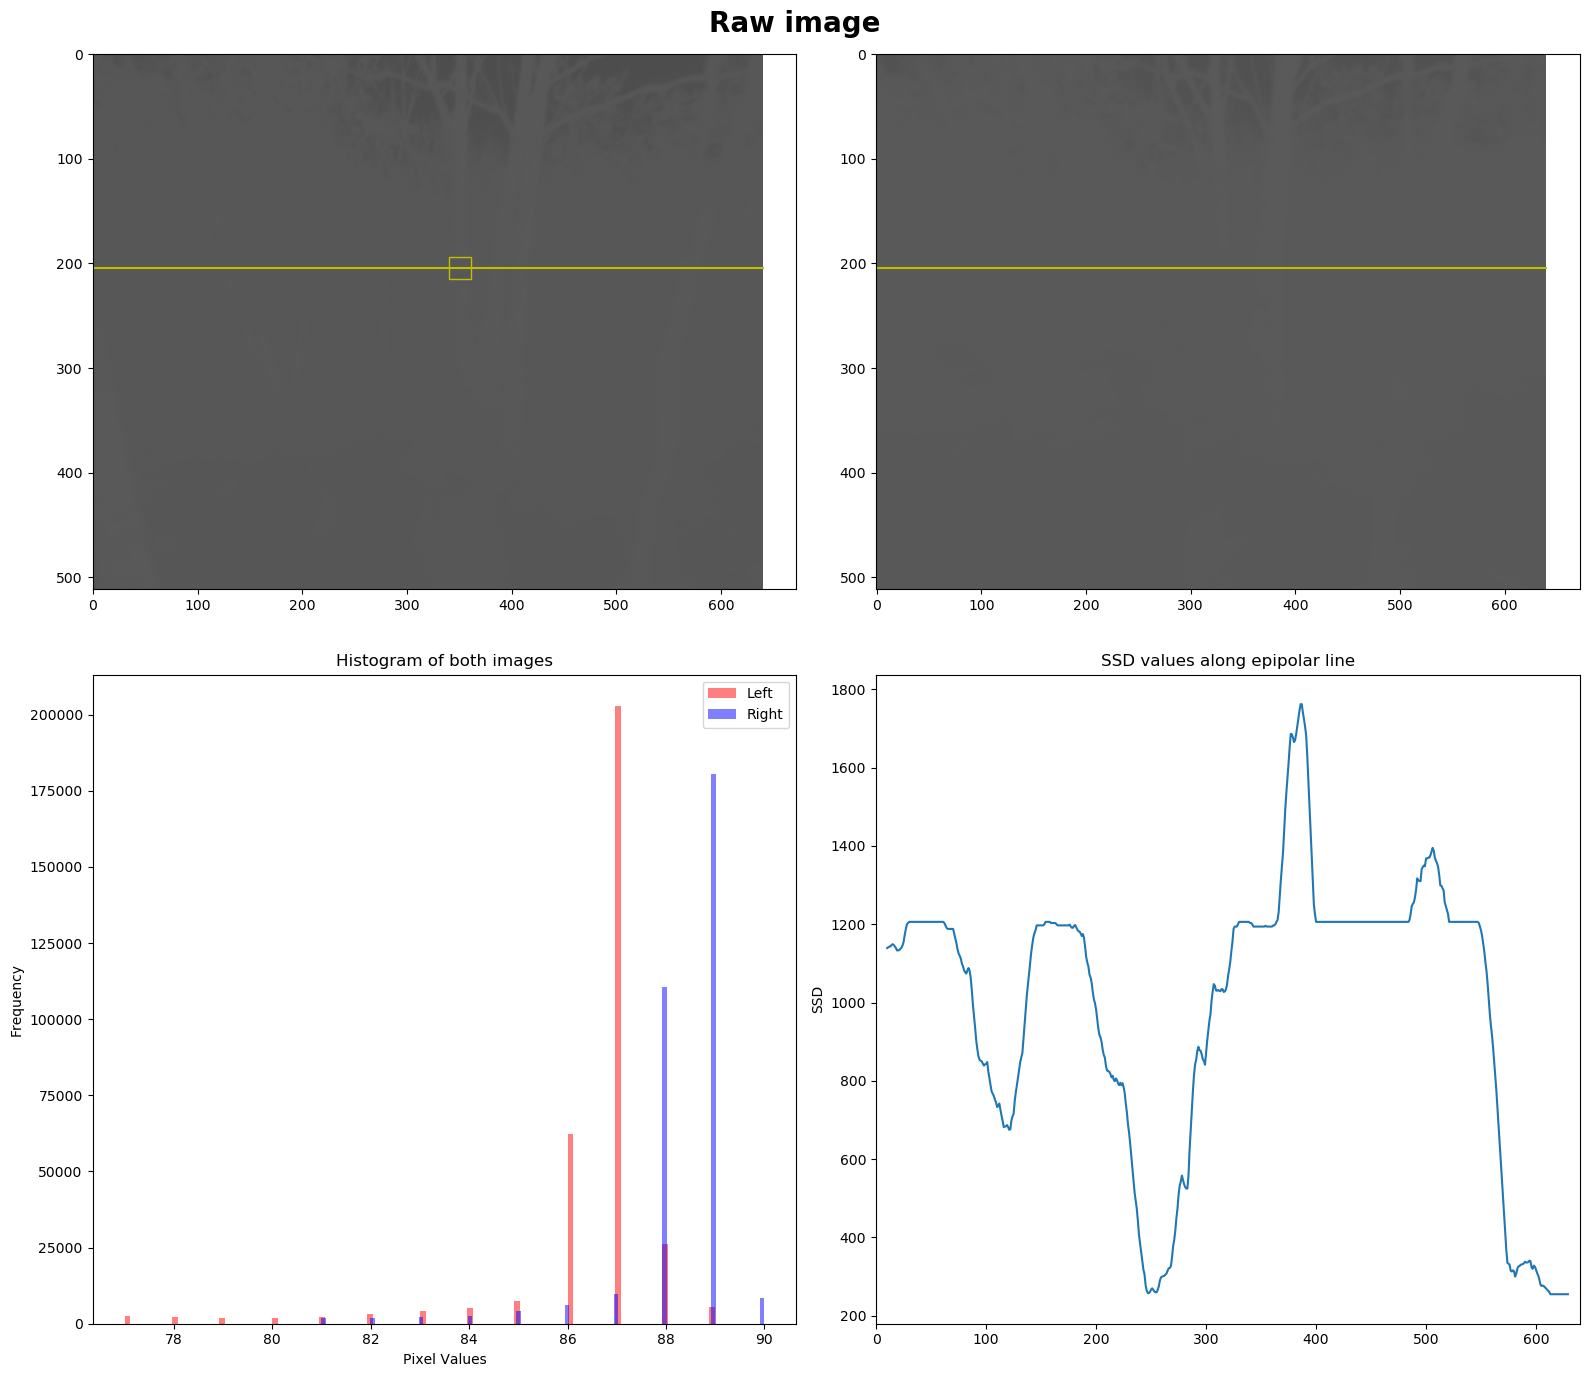

(512, 640)
(620, 2)


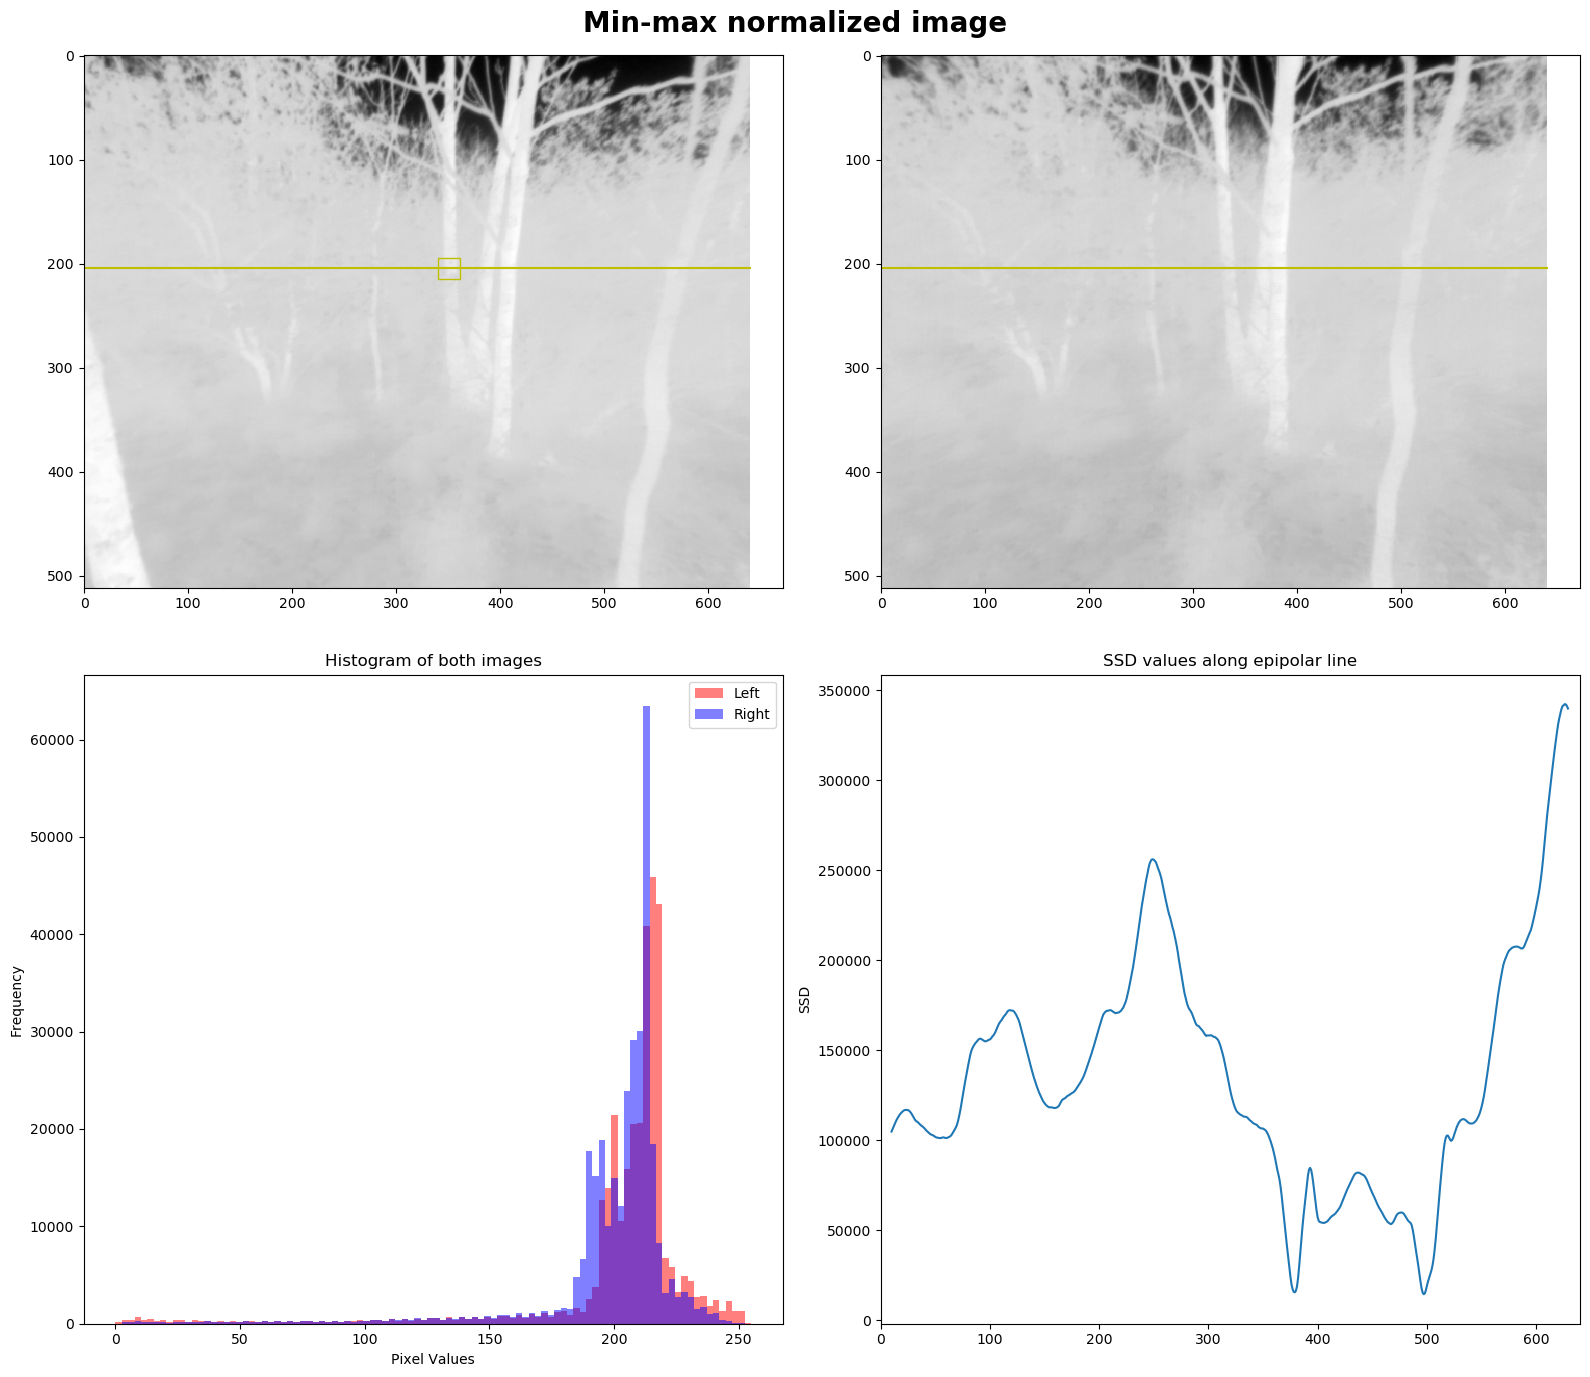

(512, 640)
(620, 2)


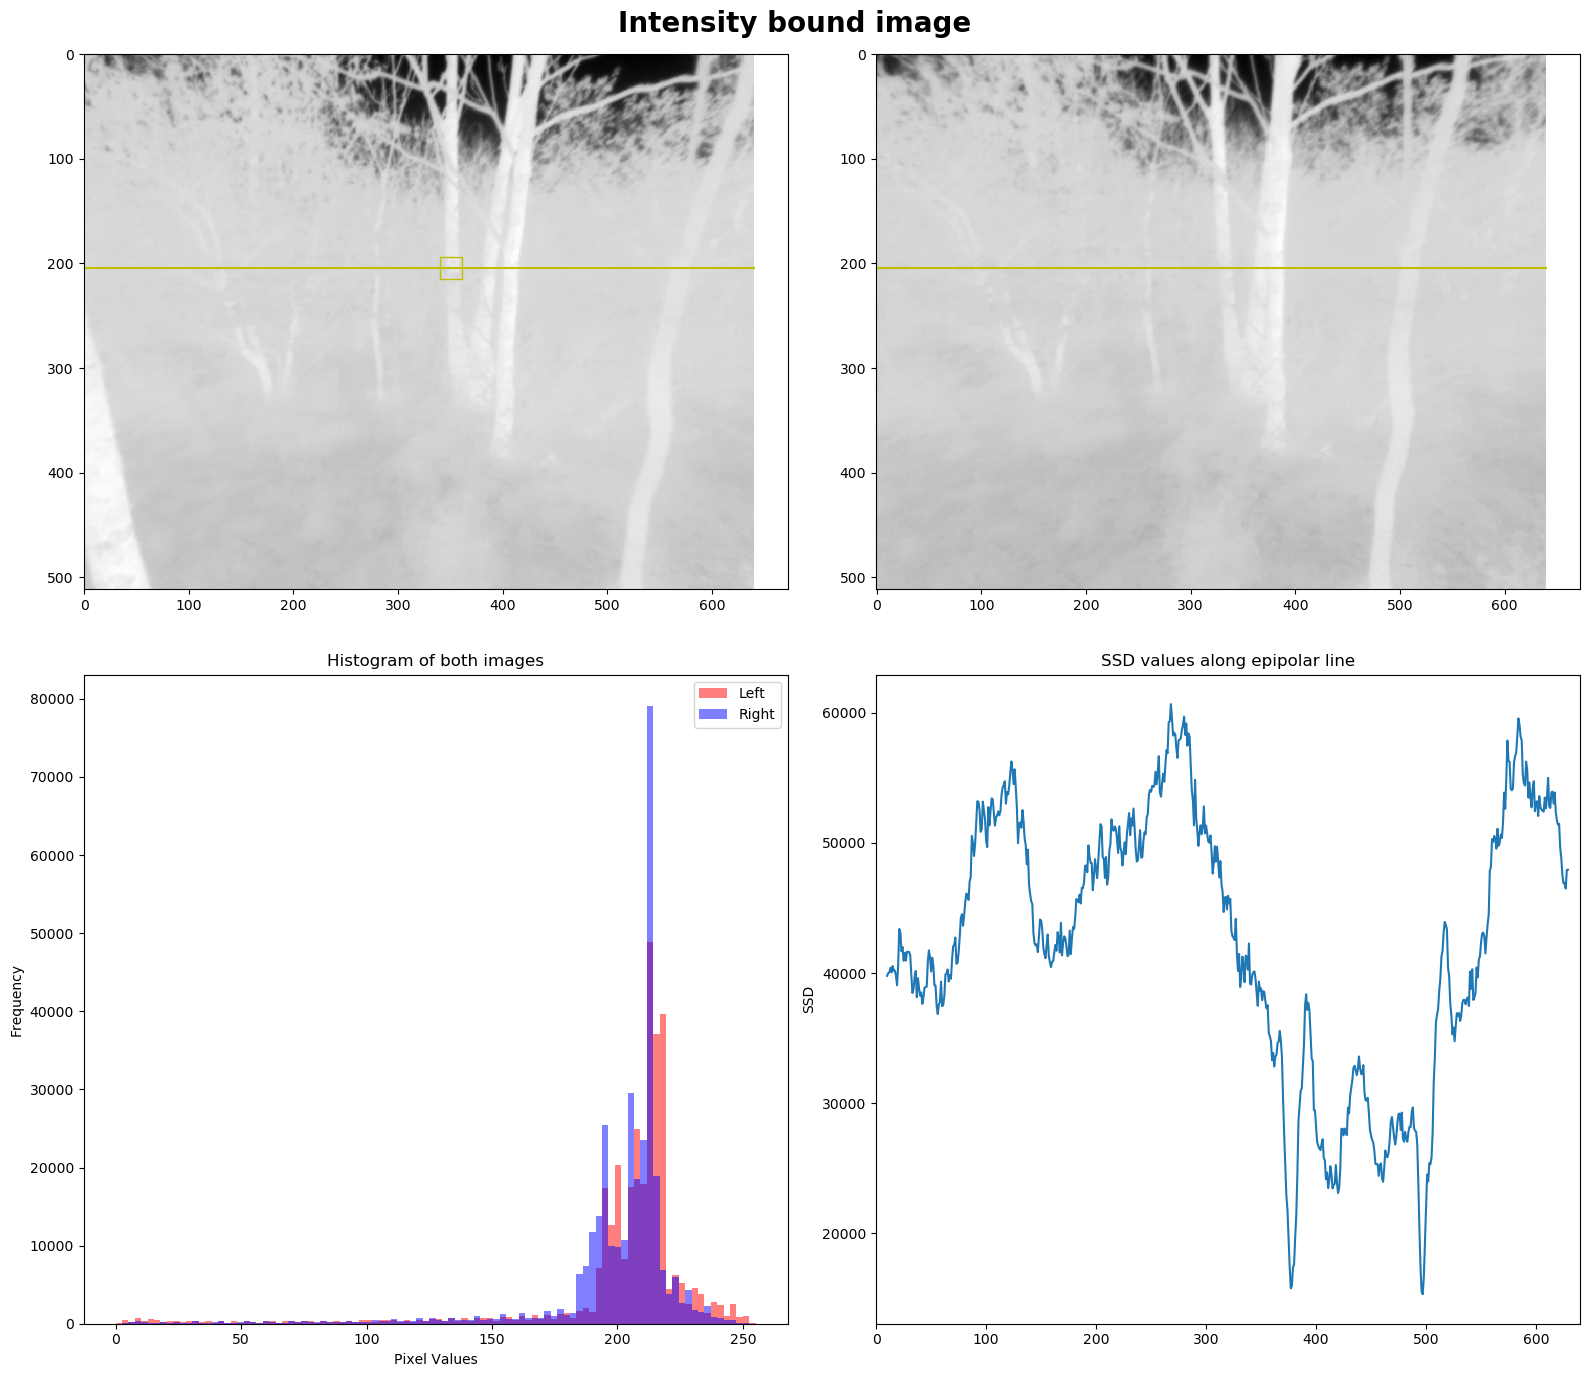

(512, 640)
(620, 2)


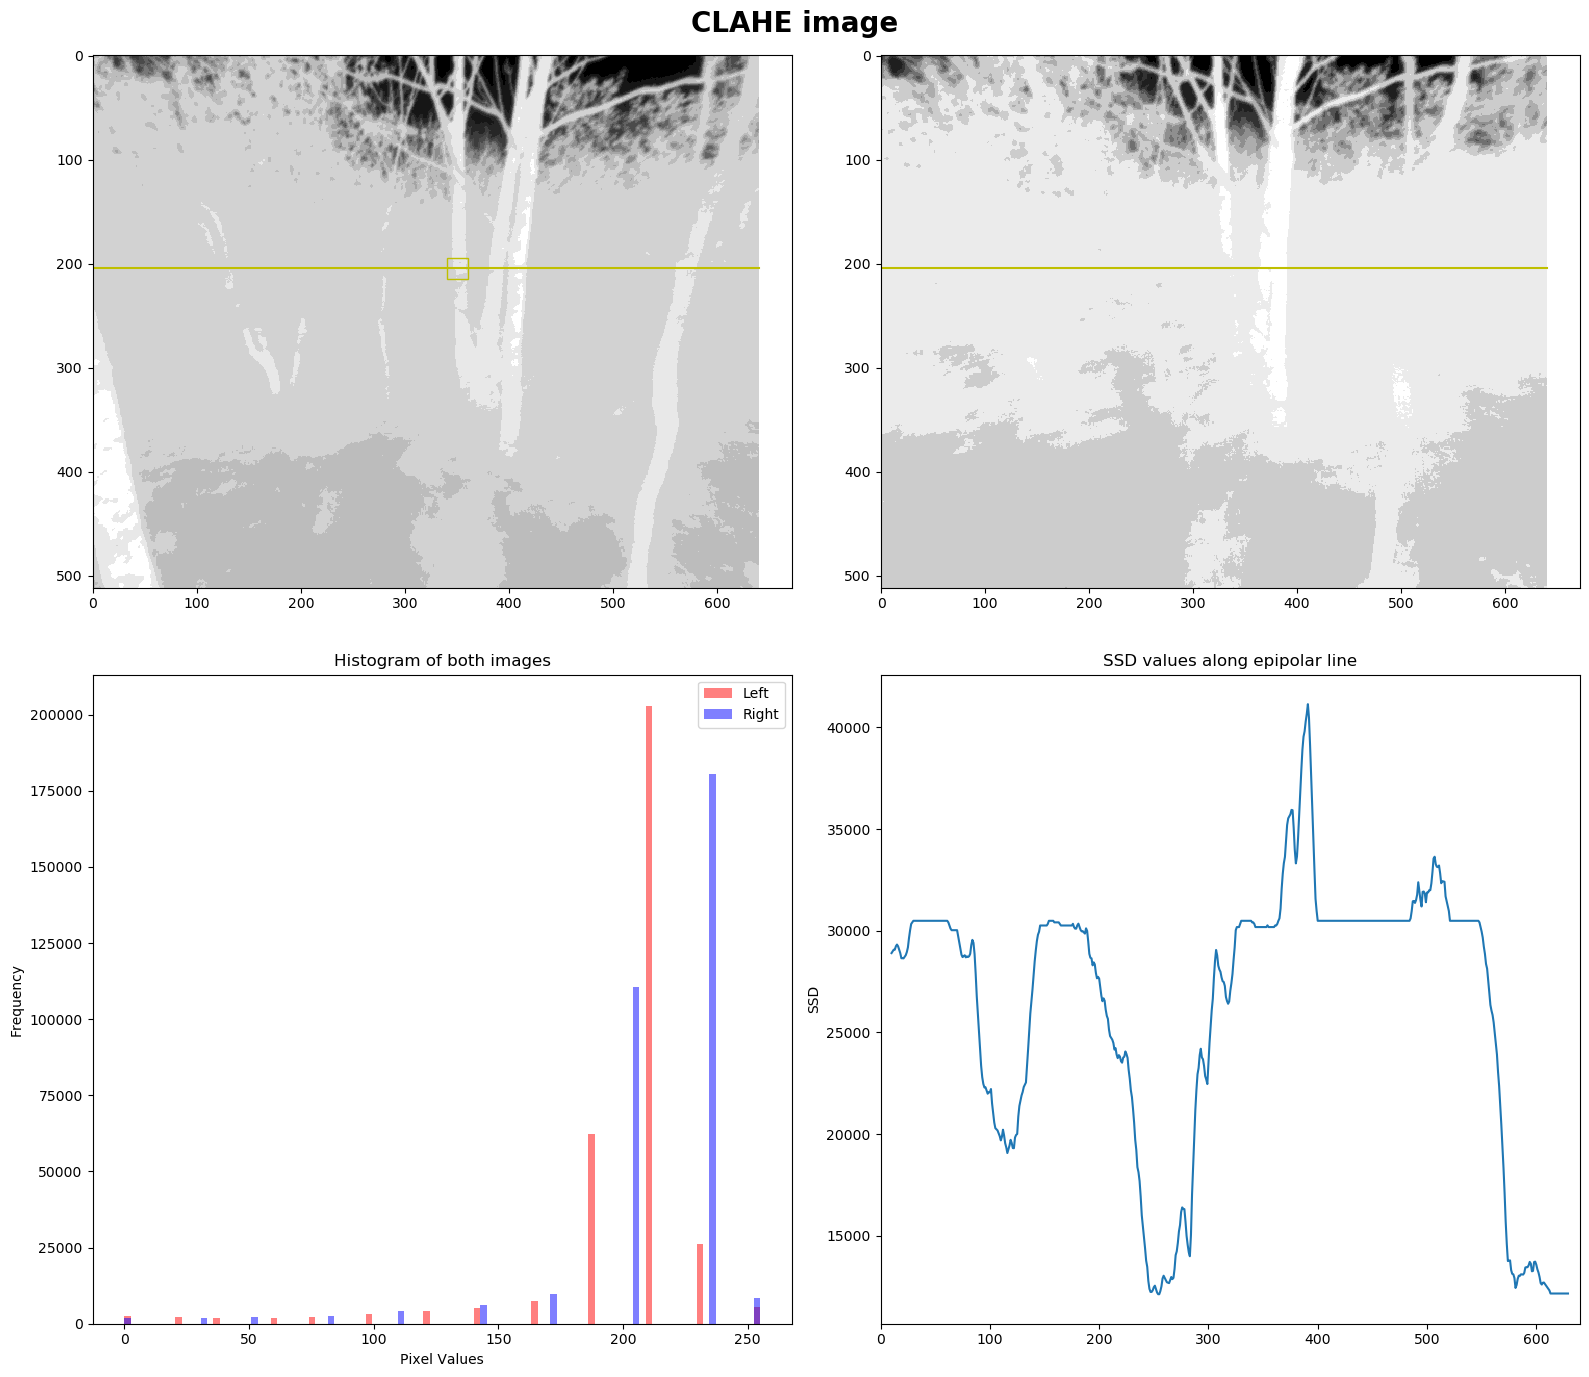

In [129]:
left_point = (350, 204)
window_size = 10
eval_metric = 'ssd'

# raw image
ncc_raw = epipolar_matching(left_point, left_rectified_8, right_rectified_8, 
                            window_size, eval_matric=eval_metric, title='Raw image')

# min-max normalize image
left_minmax = cv2.normalize(left_rectified_16, None, 0, 255, cv2.NORM_MINMAX)
right_minmax = cv2.normalize(right_rectified_16, None, 0, 255, cv2.NORM_MINMAX)
ncc_minmax = epipolar_matching(left_point, left_minmax, right_minmax, 
                               window_size, eval_matric=eval_metric, title='Min-max normalized image')

# intensity binding
lower_bound = 19000
upper_bound = 24000

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1, 1))

left_bound = intensity_binding(left_rectified_16, lower_bound, upper_bound)
# left_bound = clahe.apply(left_bound)
left_bound = cv2.normalize(left_bound, None, 0, 255, cv2.NORM_MINMAX)

right_bound = intensity_binding(right_rectified_16, lower_bound, upper_bound)
# right_bound = clahe.apply(right_bound)
right_bound = cv2.normalize(right_bound, None, 0, 255, cv2.NORM_MINMAX)

ncc_bound = epipolar_matching(left_point, left_bound, right_bound, 
                              window_size, eval_matric=eval_metric, title='Intensity bound image')


# use clahe to enhance contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1, 1))
left_clahe = clahe.apply(left_rectified_8)
right_clahe = clahe.apply(right_rectified_8)
left_clahe = cv2.normalize(left_clahe, None, 0, 255, cv2.NORM_MINMAX)
right_clahe = cv2.normalize(right_clahe, None, 0, 255, cv2.NORM_MINMAX)

ncc_clahe = epipolar_matching(left_point, left_clahe, right_clahe, 
                              window_size, eval_matric=eval_metric, title='CLAHE image')

In [130]:
def map_to_color(image):
        image = image.astype(np.float32)
        image = cv2.normalize(
            image,
            None,
            alpha=0,
            beta=255,
            norm_type=cv2.NORM_MINMAX,
            dtype=cv2.CV_8U,
        )
        # create a mask to capture only non-one values, then apply colormap
        mask = image == 0

        image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
        # for pixels with zero disparity, set color to black
        image[np.where(mask == True)] = [0, 0, 0]

        return image

def vpi_disparity(rectified_left, rectified_right):
    # cv2.imshow("rectified_left", rectified_left)
    # cv2.waitKey(0)

    with vpi.Backend.CUDA:
        left = vpi.asimage(rectified_left).convert(vpi.Format.Y16_ER, scale=1)
        right = vpi.asimage(rectified_right).convert(vpi.Format.Y16_ER, scale=1)

    disparity_image, disparity_image_cv = None, None

    confidenceU16 = vpi.Image((640, 512), vpi.Format.U16)

    maxdisp = 64

    with vpi.Backend.CUDA:
        # disparity_image = vpi.stereodisp(left, right, window=5, maxdisp=64).convert(vpi.Format.U8, scale=1.0/(32*64)*255)
        disparityS16 = vpi.stereodisp(
            left,
            right,
            downscale=1,
            out_confmap=confidenceU16,
            window=5,
            maxdisp=maxdisp,
            quality=8,
            # conftype=vpi.ConfidenceType.ABSOLUTE,
            confthreshold=500,
        )
        disparity_image = disparityS16.convert(
            vpi.Format.U8, scale=255.0 / (32 * maxdisp)
        ).cpu()
        confidenceU8 = confidenceU16.convert(
            vpi.Format.U8, scale=255.0 / 65535
        ).cpu()

    disparity_image = map_to_color(disparity_image)
    return disparity_image, confidenceU8

def stich_result_with_confidence(left, right, disparity, confidence, stereo_depth):
    # disparity = cv2.cvtColor(disparity, cv2.COLOR_GRAY2BGR)
    # disparity = stereo_depth.map_to_color(disparity)
    confidence = cv2.cvtColor(confidence, cv2.COLOR_GRAY2BGR)
    disp_conf = np.hstack((disparity, confidence))
    # left = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
    # right = cv2.cvtColor(right, cv2.COLOR_GRAY2BGR)
    left_right = np.hstack((left, right))
    combined_all = np.vstack((left_right, disp_conf))
    # print(combined_all.shape)
    return combined_all

In [131]:
left_img_firevision_orig = cv2.imread('/media/devansh/T7 Shield/wildfire_downloads/Initial_Testing_Imgs/image_174/left/left_rgb00174.png', cv2.IMREAD_UNCHANGED)
right_img_firevision_orig = cv2.imread('/media/devansh/T7 Shield/wildfire_downloads/Initial_Testing_Imgs/image_174/right/right_rgb00174.png', cv2.IMREAD_UNCHANGED)

left_img_firevision = cv2.cvtColor(left_img_firevision_orig, cv2.COLOR_BGR2GRAY)
right_img_firevision = cv2.cvtColor(right_img_firevision_orig, cv2.COLOR_BGR2GRAY)

left_img_firevision = cv2.normalize(left_img_firevision, None, 0, 255, cv2.NORM_MINMAX)
right_img_firevision = cv2.normalize(right_img_firevision, None, 0, 255, cv2.NORM_MINMAX)

# raw
left_img = left_img_firevision
right_img = right_img_firevision
disparity_image, confidenceU8 = vpi_disparity(left_img, right_img)
result = stich_result_with_confidence(left_img, right_img, disparity_image, confidenceU8, None)
plt.imshow(result)
plt.axis('off')
plt.show()

# clahe
left_img = left_bound
right_img = right_bound

disparity_image, confidenceU8 = vpi_disparity(left_img, right_img)
result = stich_result_with_confidence(left_img, right_img, disparity_image, confidenceU8, None)
plt.imshow(result)
plt.axis('off')
plt.show()

[ WARN:0@1154.817] global loadsave.cpp:244 findDecoder imread_('/media/devansh/T7 Shield/wildfire_downloads/Initial_Testing_Imgs/image_174/left/left_rgb00174.png'): can't open/read file: check file path/integrity
[ WARN:0@1154.818] global loadsave.cpp:244 findDecoder imread_('/media/devansh/T7 Shield/wildfire_downloads/Initial_Testing_Imgs/image_174/right/right_rgb00174.png'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
